# Taxi Travel Data Analysis

In this demo, we will be doing some demos on temporal feature engineering with the Kaggle Dataset

### Loading libraries, datasets

In [41]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

In [71]:
# These are all of the files you are given
df_tr = pd.read_csv("archive/train.csv")

In [43]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


### Get Computed Time from POLYLINE

Our goal is to predict the travel-time of the taxi, which can be derived from the POLYLINE length.

Recall:

```
The travel time of the trip (the prediction target of this project) is defined as the (number of points-1) x 15 seconds. 
For example, a trip with 101 data points in POLYLINE has a length of (101-1) * 15 = 1500 seconds. Some trips have missing 
data points in POLYLINE, indicated by MISSING_DATA column, and it is part of the challenge how you utilize this knowledge.
```

We are not doing anything with the MISSING_DATA. It is up to you to find a way to use (or ignore) that information.

In [72]:
#remove the MISSING_DATA rows
df_tr.drop(df_tr[df_tr["MISSING_DATA"] == True].index, inplace=True)

In [73]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [75]:
#remove the rows that have a travel time of 0
df_tr.drop(df_tr[df_tr["LEN"] == 0].index, inplace=True)

In [84]:
from datetime import datetime
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

### Create a Prediction File

In [85]:
mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
median = df_tr["LEN"].median()
print(f"{mean=} {median=} {std=}")

mean=732.0451607739321 median=615.0 std=683.8430235560546


In [86]:
# Sample submission file that is given on kaggle
df_sample = pd.read_csv("archive/sampleSubmission.csv")

df_sample["TRAVEL_TIME"] = 716.43

# mean(716.43) -> 792.73593
# median(600) -> 784.74219
df_sample.to_csv("my_pred.csv", index=None)

### Do some Feature Analysis

For our feature analysis, we are looking at which of our engineered features may be useful in making a taxicab time regression model

Using: 1656486/1674152


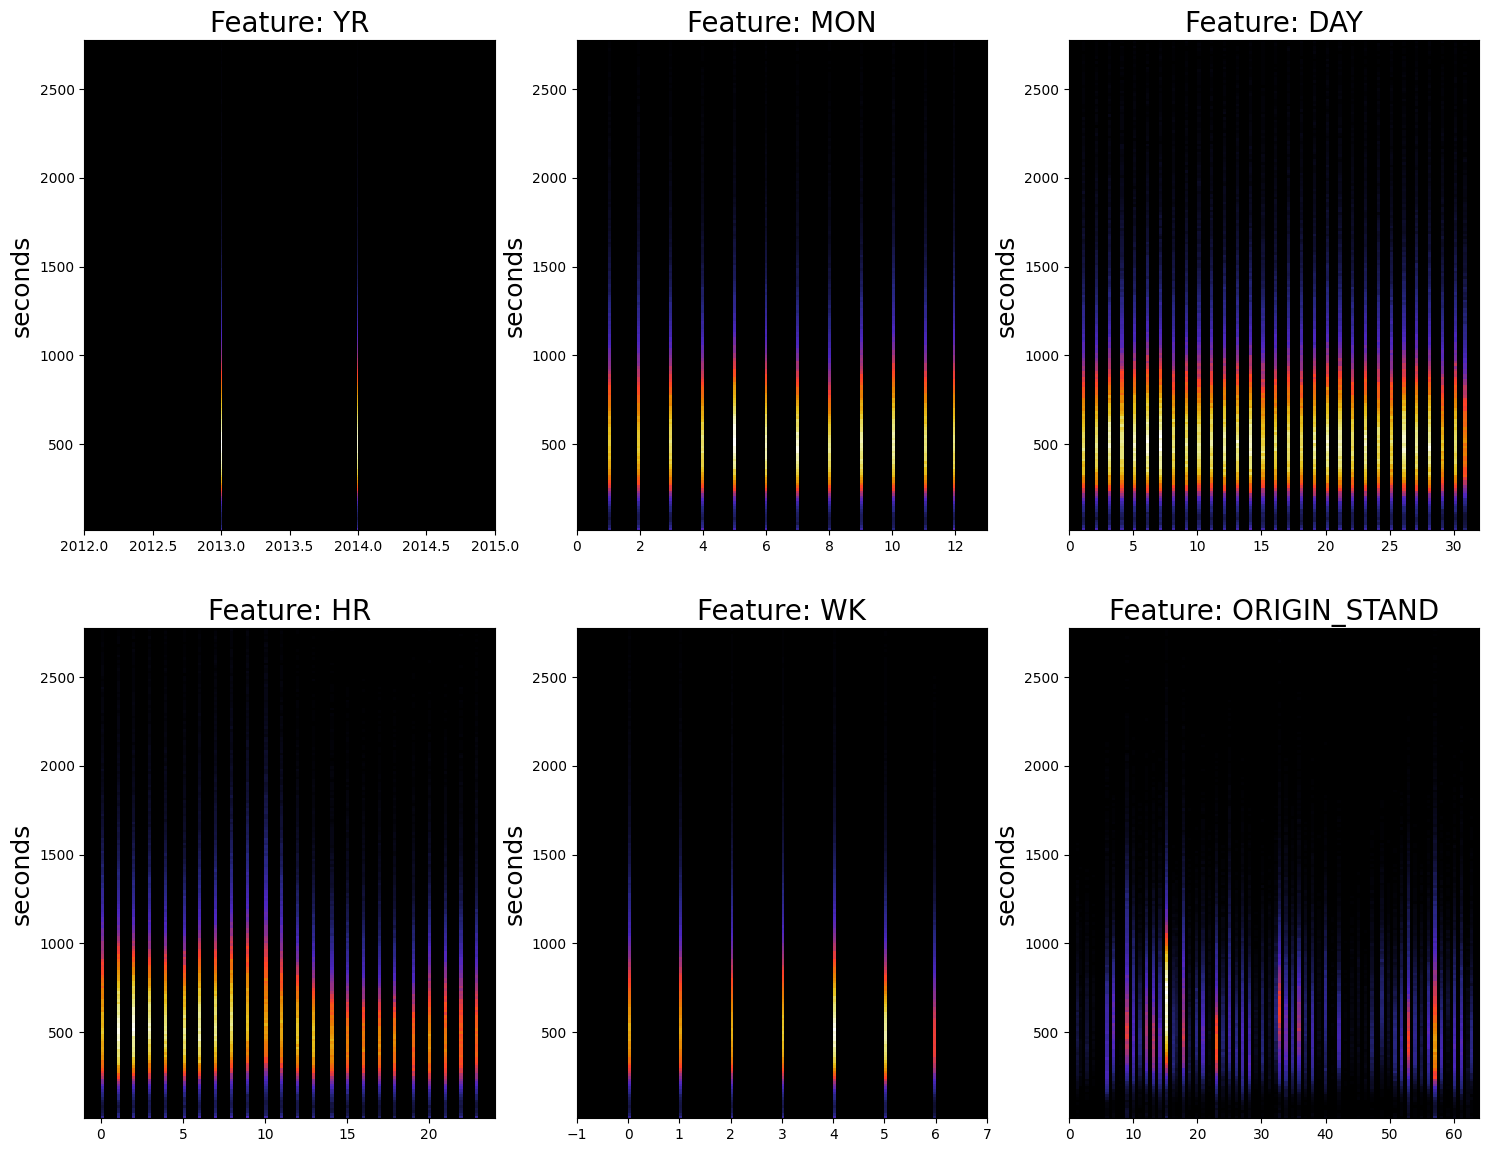

In [87]:
# First n samples to analyze. Set to -1 to use all data
end = -1

outlier_threshold = 3

# "Choose all data, where the trip length is less than 3 standard deviations away from the mean"
# This is to remove outliers. Otherwise, our plots would look very squished (since there are some
# VERRRRRY long taxi trips in the dataset)
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]

# Because our y-values only take on multiples of 15, we want just enough buckets in a histogram
# such that each buckets counts one value's frequency. (e.x. one bucket counts how many 15s trips, 
# how many 30s trips, etc. )
buckets = (int(mean + outlier_threshold * std) // 15)

print(f"Using: {len(df_trimmed)}/{len(df_tr)}")

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,14))

# Now, we visualize some features that we think might be useful
for idx, v in enumerate(["YR", "MON", "DAY", "HR", "WK", "ORIGIN_STAND"]):
  # idx // 3 = row, idx % 3 = column
  ax = axs[idx // 3, idx % 3]
  
  # Remove any rows with invalid values
  df_subset = df_trimmed.dropna(subset=v)
  
  # Create a histogram. Look up the documentation for more details
  ax.hist2d(df_subset[v][:end], df_subset["LEN"][:end], cmap="CMRmap", bins=(120,buckets))
  
  # Some stylistic things to make the graphs look nice
  ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
  ax.set_facecolor("black")
  ax.set_ylabel("seconds", fontsize=18)
  ax.set_title(f"Feature: {v}", fontsize=20)


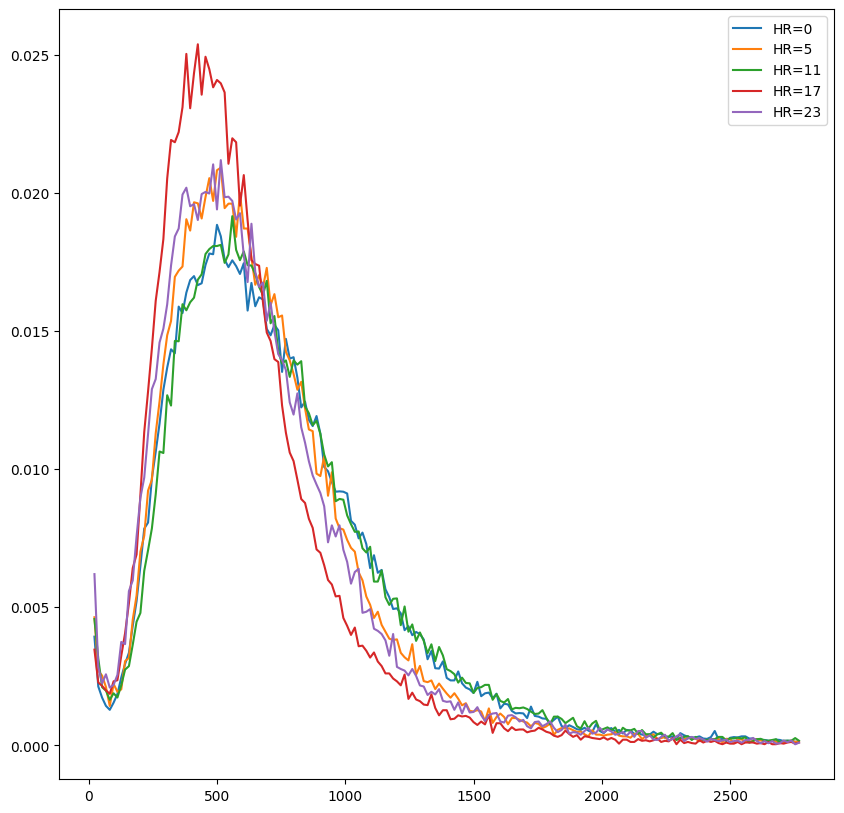

In [88]:
plt.figure(figsize=(10,10))
for v in [0, 5, 11, 17, 23]:
  # Filter data where the HR matches v
  hourly_data = df_trimmed[df_trimmed["HR"] == v]["LEN"]
  histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
  histogram = histogram / len(hourly_data)
  # The center is the left_bound and right_bound of a bucket
  bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
  plt.plot(bin_centers, histogram, label=f"HR={v}")
plt.legend();

In [89]:
#what is the train/test data size, how many dimensions of inputs/outputs
test = pd.read_csv("archive/test_public.csv")

print("The Training Data Size is: " + str(df_tr.shape))
print("The Testing Data Size is: " + str(test.shape))

The Training Data Size is: (1674152, 15)
The Testing Data Size is: (320, 8)


In [54]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,2013,6,30,17,6
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,2013,6,30,17,6
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,2013,6,30,17,6
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,6,30,17,6
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,6,30,17,6


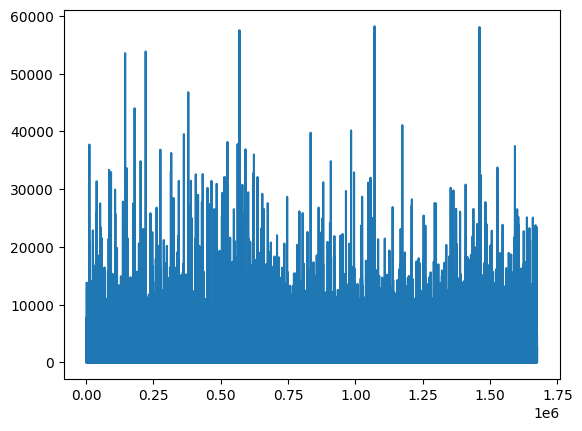

In [90]:
#travel time
travel_time = np.array(df_tr["LEN"])
plt.plot(travel_time)

<AxesSubplot: title={'center': 'Number of Taxi Rides Per Month'}, xlabel='MON', ylabel='count'>

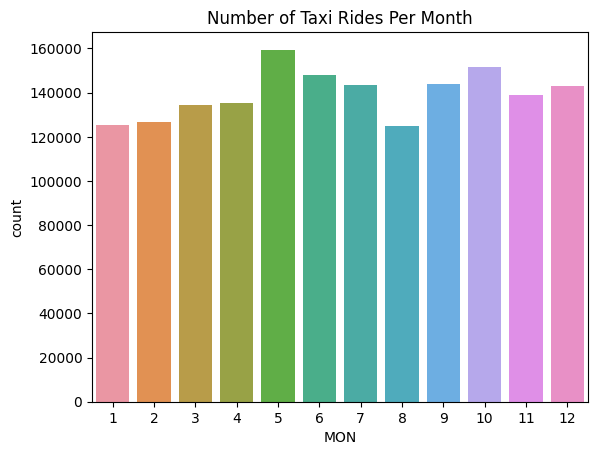

In [91]:
import seaborn

plt.title("Number of Taxi Rides Per Month")
seaborn.countplot(x='MON', data=df_tr)

<AxesSubplot: title={'center': 'Number of Taxi Rides Per Year'}, xlabel='YR', ylabel='count'>

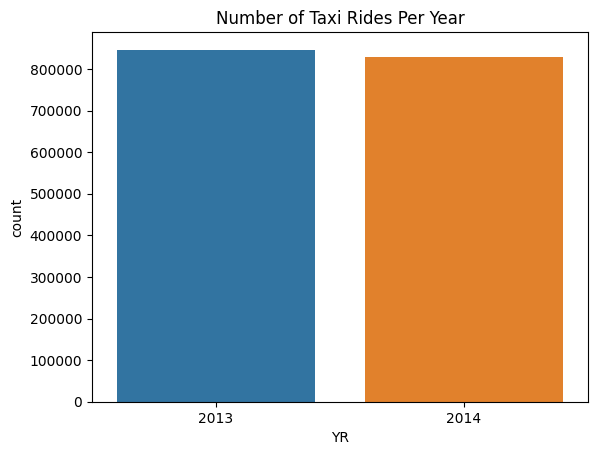

In [92]:
plt.title("Number of Taxi Rides Per Year")
seaborn.countplot(x='YR', data=df_tr)

<AxesSubplot: title={'center': 'Number of Taxi Rides Per Day'}, xlabel='count', ylabel='DAY'>

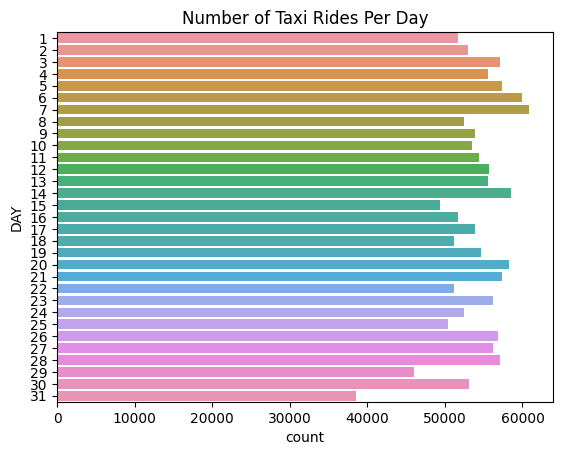

In [93]:
plt.title("Number of Taxi Rides Per Day")
seaborn.countplot(y='DAY', data=df_tr)

<AxesSubplot: title={'center': 'Number of Taxi Rides Per Hour'}, xlabel='HR', ylabel='count'>

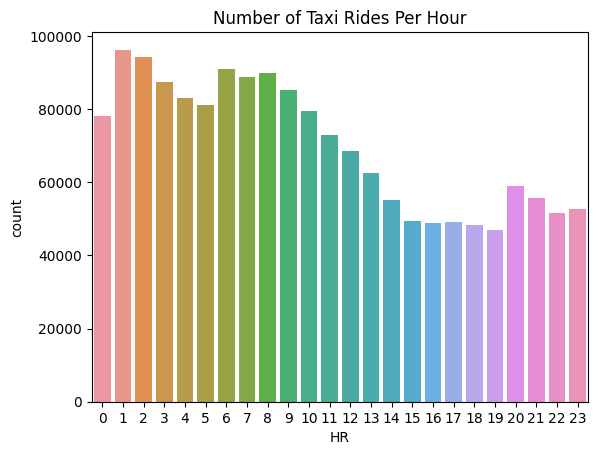

In [94]:
plt.title("Number of Taxi Rides Per Hour")
seaborn.countplot(x='HR', data=df_tr)

<AxesSubplot: title={'center': 'Number of Taxi Rides Per Week'}, xlabel='WK', ylabel='count'>

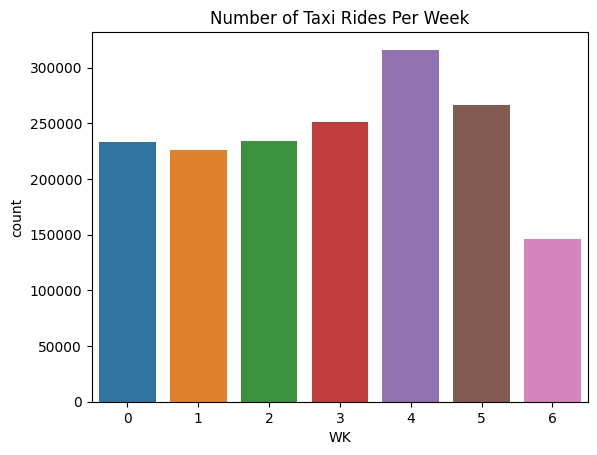

In [95]:
plt.title("Number of Taxi Rides Per Week")
seaborn.countplot(x='WK', data=df_tr)

In [99]:
print("On average, the travel time is: "+ str(df_tr["LEN"].mean()))
print("On average, the number of taxi trips per day is: " + str(df_tr["DAY"].mean()))
print("On average, the number of taxi trips per month is: " + str(df_tr["MON"].mean()))
print("On average, the number of taxi trips per week is: " + str(df_tr["WK"].mean()))

On average, the travel time is: 732.0451607739321
On average, the number of taxi trips per day is: 15.732520703018603
On average, the number of taxi trips per month is: 6.608202839407652
On average, the number of taxi trips per week is: 2.940856624727026
